#WGAN model with GRU generator and CNN discriminator 
trains on 7 datastamps and predicts stock price for 1 day

##loading data

In [107]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from matplotlib.dates import DateFormatter
from sklearn.preprocessing import MinMaxScaler
import math
import datetime 
import xgboost as xgb
from sklearn.metrics import accuracy_score

In [108]:
def parser(x):
    return datetime.datetime.strptime(x,'%Y-%m-%d')     #converts 2000-10-13 into 2000-10-13 00:00:00 <class 'datetime.datetime'>

In [109]:
!pip install yfinance

In [110]:
import yfinance as yf

# Get the data for the stock goldman sachs
start = '2013-01-01'
end = '2019-07-05'

data = yf.download('GS', start,end,parse_dates=True, date_parser=parser)
data_sp = yf.download('sp', start,end,parse_dates=True, date_parser=parser)
data_nasdaq = yf.download('^IXIC', start,end,parse_dates=True, date_parser=parser)
data_nyse = yf.download('^NYA', start,end,parse_dates=True, date_parser=parser)
data_oil = yf.download('CL=F', start,end,parse_dates=True, date_parser=parser)
data_gold = yf.download('GC=F', start,end,parse_dates=True, date_parser=parser)
data_usd = yf.download('DX-Y.NYB', start,end,parse_dates=True, date_parser=parser)
data_morgan = yf.download('MS', start,end,parse_dates=True, date_parser=parser)
data.drop('High', inplace=True, axis=1)
data.drop('Low', inplace=True, axis=1)
data.drop('Open', inplace=True, axis=1)
data.drop('Adj Close', inplace=True, axis=1)

data['sp']=data_sp['Close']
data['nasdaq']=data_nasdaq['Close']
data['nyse']=data_nyse['Close']
data['oil']=data_oil['Close']
data['gold']=data_gold['Close']
data['usd_index']=data_usd['Close']
data['MS']=data_morgan['Close']
data = data.reset_index()

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [111]:
data.head()

,Date,Close,Volume,sp,nasdaq,nyse,oil,gold,usd_index,MS
0,2013-01-02,131.660004,4449000,22.160000,3112.260010,8632.009766,93.120003,1687.900024,79.849998,19.620001
1,2013-01-03,130.940002,4584600,22.350000,3100.570068,8607.790039,92.919998,1673.699951,80.430000,19.580000
2,2013-01-04,134.509995,5234600,22.200001,3101.659912,8667.679688,93.089996,1648.099976,80.500000,20.190001
3,2013-01-07,134.259995,3556900,21.910000,3098.810059,8636.910156,93.190002,1645.500000,80.260002,19.799999
4,2013-01-08,133.050003,2760200,21.879999,3091.810059,8604.379883,93.150002,1661.500000,80.349998,19.650000


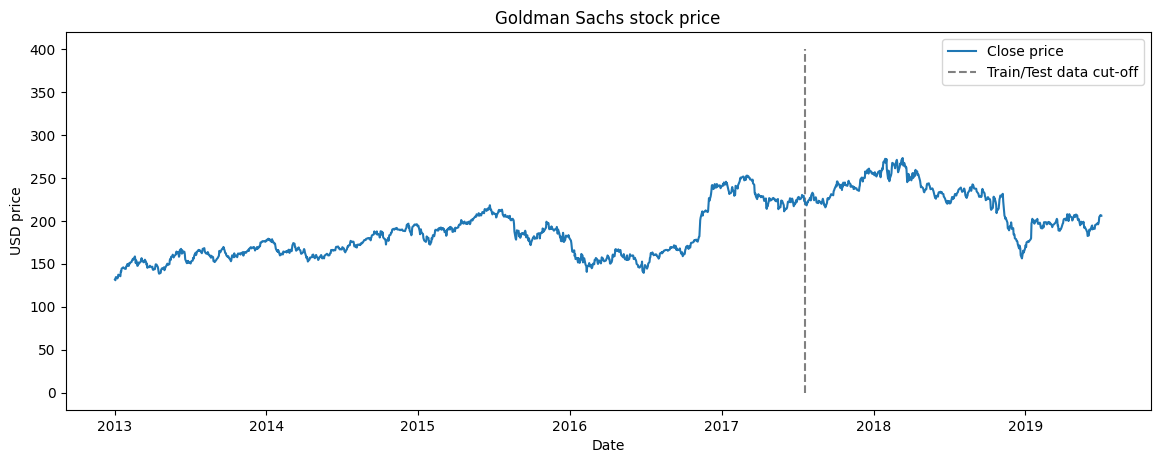

In [112]:
plt.figure(figsize=(14, 5), dpi=100)
plt.plot(data['Date'], data['Close'], label='Close price')
plt.vlines(data.iloc[int(data.shape[0]*.7)].Date, 0, 400, linestyles='--', colors='gray', label='Train/Test data cut-off')
plt.xlabel('Date')
plt.ylabel('USD price')
plt.title('Goldman Sachs stock price')
plt.legend()
plt.show()

In [113]:
print('There are {} number of days in the dataset.'.format(data.shape[0]))
num_training_days = int(data.shape[0]*.7)
print('Number of training days: {}. Number of test days: {}.'.format(num_training_days, data.shape[0]-num_training_days))

There are 1637 number of days in the dataset.
Number of training days: 1145. Number of test days: 492.


##technical indicators

In [114]:
def get_technical_indicators(dataset):
    # Create 7 and 21 days Moving Average
    dataset['ma7'] = dataset['Close'].rolling(window=7).mean()
    dataset['ma21'] = dataset['Close'].rolling(window=21).mean()
    
    # Create MACD (Moving average convergence divergence)
    #EMA = exponential moving average
    dataset['26ema'] = dataset['Close'].ewm(span=26).mean()
    dataset['12ema'] = dataset['Close'].ewm(span=12).mean()
    dataset['MACD'] = (dataset['12ema']-dataset['26ema'])

    # Create Bollinger Bands
    mean=dataset['Close'].rolling(window=20).mean()
    std=dataset['Close'].rolling(window=20).std()
    dataset['upper_band'] = mean + (std*2)
    dataset['lower_band'] = mean - (std*2)
    
    # Create Exponential moving average
    dataset['ema'] = dataset['Close'].ewm(com=0.5).mean()
    
    # Create Momentum
    dataset['momentum'] = dataset['Close']-1
    dataset["log_momentum"] = np.log(dataset["momentum"])
    
    return dataset

In [115]:
data = get_technical_indicators(data)
data = data[20:]    #drop first 20 rows
data.reset_index(drop=True, inplace=True)
data.head()

,Date,Close,Volume,sp,nasdaq,nyse,oil,gold,usd_index,MS,ma7,ma21,26ema,12ema,MACD,upper_band,lower_band,ema,momentum,log_momentum
0,2013-01-31,147.860001,3680900,20.959999,3142.129883,8894.709961,97.489998,1660.599976,79.209999,22.850000,145.891429,139.938095,142.301103,144.346203,2.045101,151.460948,129.243052,147.514972,146.860001,4.989480
1,2013-02-01,149.899994,4563800,21.320000,3179.100098,8965.120117,97.769997,1669.400024,79.129997,23.510000,146.511429,140.806666,142.990857,145.222851,2.231994,152.262096,130.337903,149.104987,148.899994,5.003275
2,2013-02-04,147.520004,4679400,20.740000,3131.169922,8852.790039,96.169998,1675.300049,79.550003,22.879999,146.877143,141.596190,143.395219,145.584004,2.188786,152.759046,131.141954,148.048332,146.520004,4.987162
3,2013-02-05,150.449997,4219200,20.940001,3171.580078,8920.129883,96.639999,1672.400024,79.489998,23.400000,147.732856,142.355238,144.015634,146.346454,2.330820,153.568466,131.951534,149.649442,149.449997,5.006962
4,2013-02-06,151.119995,3940600,21.150000,3168.479980,8934.240234,96.620003,1677.699951,79.720001,23.389999,148.728570,143.158095,144.631863,147.092297,2.460434,154.067832,133.259166,150.629811,150.119995,5.011435


In [116]:
def plot_technical_indicators(dataset, last_days):
    plt.figure(figsize=(14, 10), dpi=100)
    shape_0 = dataset.shape[0]
    xmacd_ = shape_0-last_days

    dataset = dataset.iloc[-last_days:, :]
    x_ = range(3, dataset.shape[0])
    x_ =list(dataset.index)

    # Plot first subplot
    plt.subplot(2, 1, 1)
    plt.plot(dataset['ma7'],label='MA 7', color='g',linestyle='--')
    plt.plot(dataset['Close'],label='Closing Price', color='b')
    plt.plot(dataset['ma21'],label='MA 21', color='r',linestyle='--')
    plt.plot(dataset['upper_band'],label='Upper Band', color='c')
    plt.plot(dataset['lower_band'],label='Lower Band', color='c')
    plt.fill_between(x_, dataset['lower_band'], dataset['upper_band'], alpha=0.35)
    plt.title('Technical indicators for Goldman Sachs - last {} days.'.format(last_days))
    plt.ylabel('USD')
    plt.legend()

    # Plot second subplot
    plt.subplot(2, 1, 2)
    plt.title('MACD')
    plt.plot(dataset['MACD'],label='MACD', linestyle='-.')
    plt.hlines(15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.hlines(-15, xmacd_, shape_0, colors='g', linestyles='--')
    plt.plot(dataset['log_momentum'],label='Momentum', color='b',linestyle='-')

    plt.legend()
    plt.show()

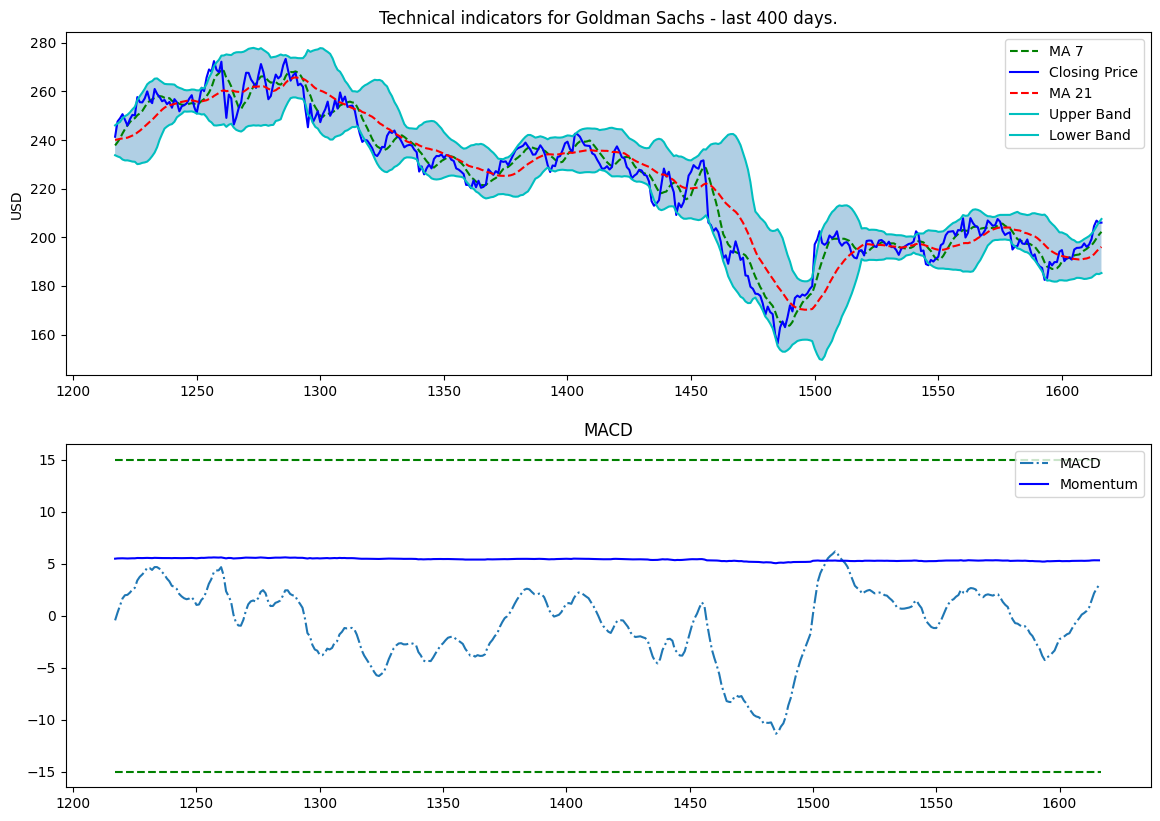

In [117]:
plot_technical_indicators(data, 400)

##fourier analysis

In [118]:
def get_fourier_transfer(dataset):
    # Get the columns for doing fourier
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    fft_com_df = pd.DataFrame()
    for num_ in [3, 6, 9]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        fft_ = np.fft.ifft(fft_list_m10)
        fft_com = pd.DataFrame({'fft': fft_})
        fft_com['absolute of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.abs(x))
        fft_com['angle of ' + str(num_) + ' comp'] = fft_com['fft'].apply(lambda x: np.angle(x))
        fft_com = fft_com.drop(columns='fft')
        fft_com_df = pd.concat([fft_com_df, fft_com], axis=1)

    return fft_com_df

In [119]:
dataset_F = get_fourier_transfer(data)
data = pd.concat([data, dataset_F], axis=1)

data.head()

,Date,Close,Volume,sp,nasdaq,nyse,oil,gold,usd_index,MS,ma7,ma21,26ema,12ema,MACD,upper_band,lower_band,ema,momentum,log_momentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
0,2013-01-31,147.860001,3680900,20.959999,3142.129883,8894.709961,97.489998,1660.599976,79.209999,22.850000,145.891429,139.938095,142.301103,144.346203,2.045101,151.460948,129.243052,147.514972,146.860001,4.989480,171.780426,0.008289,173.004471,-0.023409,176.380681,-0.010303
1,2013-02-01,149.899994,4563800,21.320000,3179.100098,8965.120117,97.769997,1669.400024,79.129997,23.510000,146.511429,140.806666,142.990857,145.222851,2.231994,152.262096,130.337903,149.104987,148.899994,5.003275,171.582778,0.008060,172.739373,-0.023358,175.911505,-0.010177
2,2013-02-04,147.520004,4679400,20.740000,3131.169922,8852.790039,96.169998,1675.300049,79.550003,22.879999,146.877143,141.596190,143.395219,145.584004,2.188786,152.759046,131.141954,148.048332,146.520004,4.987162,171.386123,0.007829,172.474494,-0.023294,175.439029,-0.010038
3,2013-02-05,150.449997,4219200,20.940001,3171.580078,8920.129883,96.639999,1672.400024,79.489998,23.400000,147.732856,142.355238,144.015634,146.346454,2.330820,153.568466,131.951534,149.649442,149.449997,5.006962,171.190467,0.007597,172.209886,-0.023218,174.963482,-0.009886
4,2013-02-06,151.119995,3940600,21.150000,3168.479980,8934.240234,96.620003,1677.699951,79.720001,23.389999,148.728570,143.158095,144.631863,147.092297,2.460434,154.067832,133.259166,150.629811,150.119995,5.011435,170.995815,0.007363,171.945600,-0.023128,174.485094,-0.009722


/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


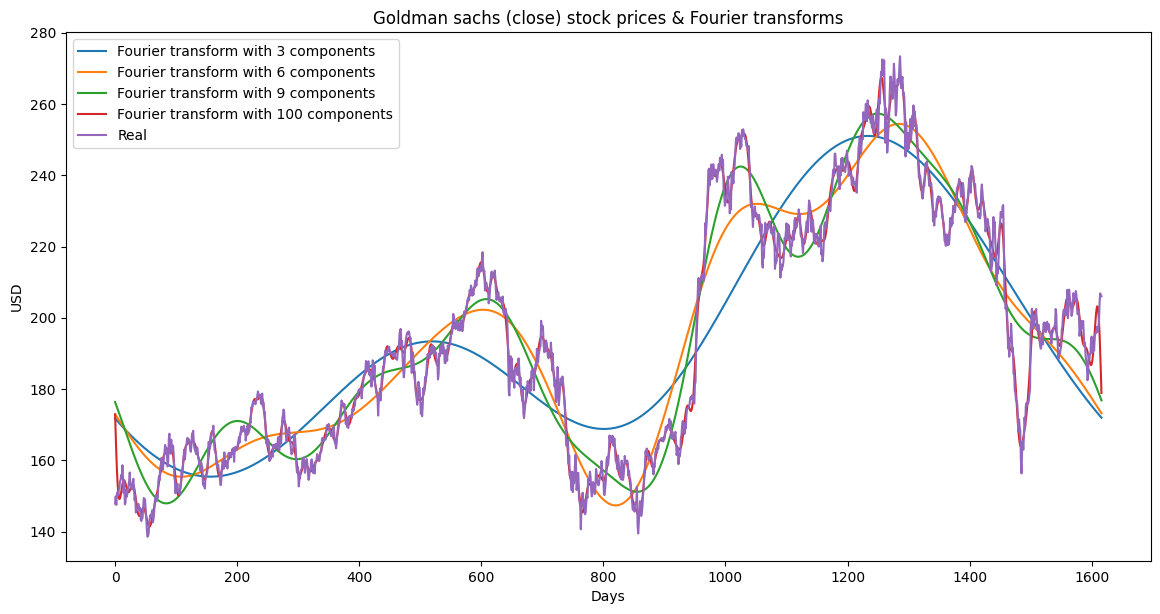

In [120]:
def plot_Fourier(dataset):
    data_FT = dataset[['Date', 'Close']]

    close_fft = np.fft.fft(np.asarray(data_FT['Close'].tolist()))
    fft_df = pd.DataFrame({'fft': close_fft})
    fft_df['absolute'] = fft_df['fft'].apply(lambda x: np.abs(x))
    fft_df['angle'] = fft_df['fft'].apply(lambda x: np.angle(x))

    fft_list = np.asarray(fft_df['fft'].tolist())
    plt.figure(figsize=(14, 7), dpi=100)
    fft_list = np.asarray(fft_df['fft'].tolist())
    for num_ in [3, 6, 9, 100]:
        fft_list_m10 = np.copy(fft_list);
        fft_list_m10[num_:-num_] = 0
        plt.plot(np.fft.ifft(fft_list_m10), label='Fourier transform with {} components'.format(num_))
    plt.plot(data_FT['Close'], label='Real')
    plt.xlabel('Days')
    plt.ylabel('USD')
    plt.title('Goldman sachs (close) stock prices & Fourier transforms')
    plt.legend()
    plt.show()

plot_Fourier(data)

##ARIMA


In [121]:
from statsmodels.tsa.arima_model import ARIMA
from pandas import DataFrame
from pandas import datetime

series = data['Close']
model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  This is separate from the ipykernel package so we can avoid doing imports until


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 1616
Model:                 ARIMA(5, 1, 0)   Log Likelihood               -3938.908
Method:                       css-mle   S.D. of innovations              2.769
Date:                Sat, 17 Jul 2021   AIC                           7891.816
Time:                        20:36:18   BIC                           7929.530
Sample:                             1   HQIC                          7905.813
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0356      0.066      0.540      0.589      -0.094       0.165
ar.L1.D.Close     0.0111      0.025      0.446      0.656      -0.038       0.060
ar.L2.D.Close     0.0040      0.025     

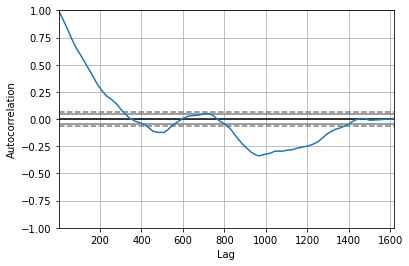

<Figure size 800x560 with 0 Axes>

In [122]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(series)
plt.figure(figsize=(10, 7), dpi=80)
plt.show()

In [123]:
from pandas import read_csv
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

X = series.values
size = int(len(X) * 0.66)
train, test = X[0:size], X[size:len(X)]
history = [x for x in train]
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,1,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  


In [124]:
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

Test MSE: 10.911


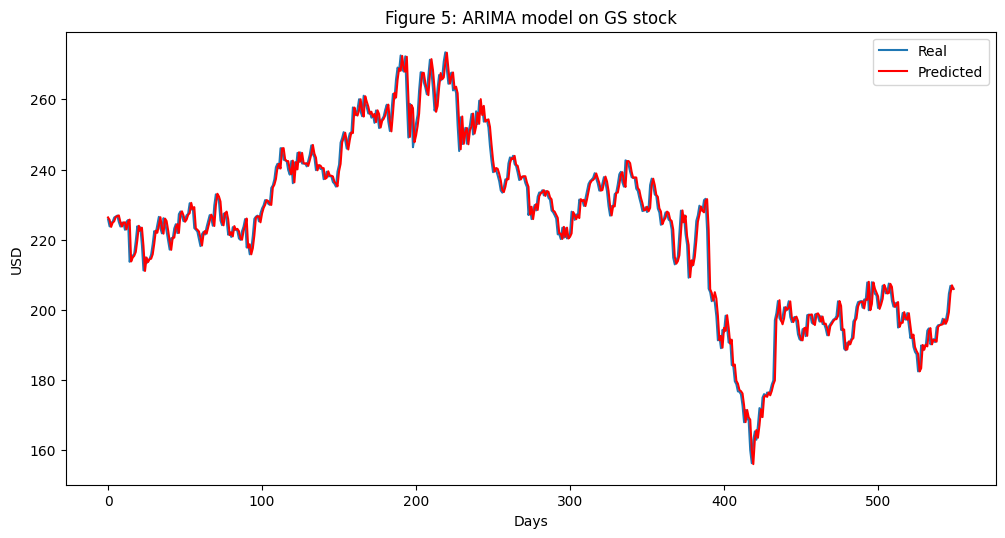

In [125]:
# Plot the predicted (from ARIMA) and real prices

plt.figure(figsize=(12, 6), dpi=100)
plt.plot(test, label='Real')
plt.plot(predictions, color='red', label='Predicted')
plt.xlabel('Days')
plt.ylabel('USD')
plt.title('Figure 5: ARIMA model on GS stock')
plt.legend()
plt.show()

##Feature Engineering

we will use XGBoost to compare the importance of different feature 

In [126]:
print('Total dataset has {} samples, and {} features.'.format(data.shape[0], data.shape[1]))

Total dataset has 1617 samples, and 26 features.


In [127]:
def get_feature_importance_data(data_income):
    data = data_income.copy()
    y = data['Close']
    X = data.iloc[:, 1:]
    X = X.drop(columns=['Close'])
    
    train_samples = int(X.shape[0] * 0.65)
 
    X_train = X.iloc[:train_samples]
    X_test = X.iloc[train_samples:]

    y_train = y.iloc[:train_samples]
    y_test = y.iloc[train_samples:]
    
    return (X_train, y_train), (X_test, y_test)

In [128]:
# Get training and test data
(X_train_FI, y_train_FI), (X_test_FI, y_test_FI) = get_feature_importance_data(data)

In [129]:
regressor = xgb.XGBRegressor(gamma=0.0,n_estimators=150,base_score=0.7,colsample_bytree=1,learning_rate=0.05)

In [130]:
eval_set = [(X_train_FI, y_train_FI), (X_test_FI, y_test_FI)]
xgbModel = regressor.fit(X_train_FI,y_train_FI, eval_set=eval_set, verbose=False)

[20:38:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [131]:
eval_result = regressor.evals_result()

In [132]:
training_rounds = range(len(eval_result['validation_0']['rmse']))

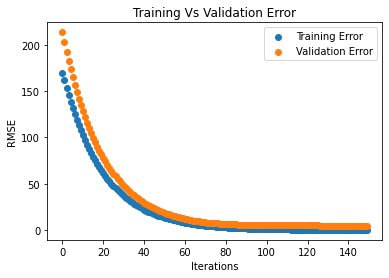

In [133]:
plt.scatter(x=training_rounds,y=eval_result['validation_0']['rmse'],label='Training Error')
plt.scatter(x=training_rounds,y=eval_result['validation_1']['rmse'],label='Validation Error')
plt.xlabel('Iterations')
plt.ylabel('RMSE')
plt.title('Training Vs Validation Error')
plt.legend()
plt.show()

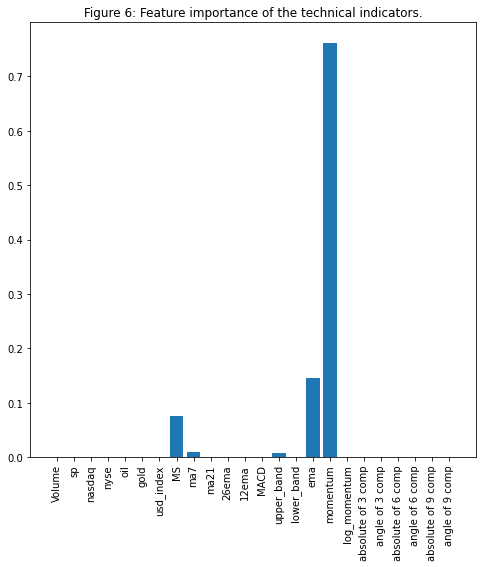

In [134]:
fig = plt.figure(figsize=(8,8))
plt.xticks(rotation='vertical')
plt.bar([i for i in range(len(xgbModel.feature_importances_))], xgbModel.feature_importances_.tolist(), tick_label=X_test_FI.columns)
plt.title('Figure 6: Feature importance of the technical indicators.')
plt.show()

##GAN model

In [135]:
import os
import pandas as pd
import numpy as np
import pandas as pd
import statsmodels.api as sm
from numpy import *
from math import sqrt
from pandas import *
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from pickle import dump

In [136]:
datetime_series = pd.to_datetime(data['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
data = data.set_index(datetime_index)
data = data.sort_values(by='Date')
data = data.drop(columns='Date')

In [137]:
data

,Close,Volume,sp,nasdaq,nyse,oil,gold,usd_index,MS,ma7,ma21,26ema,12ema,MACD,upper_band,lower_band,ema,momentum,log_momentum,absolute of 3 comp,angle of 3 comp,absolute of 6 comp,angle of 6 comp,absolute of 9 comp,angle of 9 comp
2013-01-31,147.860001,3680900,20.959999,3142.129883,8894.709961,97.489998,1660.599976,79.209999,22.850000,145.891429,139.938095,142.301103,144.346203,2.045101,151.460948,129.243052,147.514972,146.860001,4.989480,171.780426,0.008289,173.004471,-0.023409,176.380681,-0.010303
2013-02-01,149.899994,4563800,21.320000,3179.100098,8965.120117,97.769997,1669.400024,79.129997,23.510000,146.511429,140.806666,142.990857,145.222851,2.231994,152.262096,130.337903,149.104987,148.899994,5.003275,171.582778,0.008060,172.739373,-0.023358,175.911505,-0.010177
2013-02-04,147.520004,4679400,20.740000,3131.169922,8852.790039,96.169998,1675.300049,79.550003,22.879999,146.877143,141.596190,143.395219,145.584004,2.188786,152.759046,131.141954,148.048332,146.520004,4.987162,171.386123,0.007829,172.474494,-0.023294,175.439029,-0.010038
2013-02-05,150.449997,4219200,20.940001,3171.580078,8920.129883,96.639999,1672.400024,79.489998,23.400000,147.732856,142.355238,144.015634,146.346454,2.330820,153.568466,131.951534,149.649442,149.449997,5.006962,171.190467,0.007597,172.209886,-0.023218,174.963482,-0.009886
2013-02-06,151.119995,3940600,21.150000,3168.479980,8934.240234,96.620003,1677.699951,79.720001,23.389999,148.728570,143.158095,144.631863,147.092297,2.460434,154.067832,133.259166,150.629811,150.119995,5.011435,170.995815,0.007363,171.945600,-0.023128,174.485094,-0.009722
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-27,199.320007,2239200,32.060001,7967.759766,12965.320312,59.430000,1408.400024,96.190002,43.490002,196.737143,192.197143,194.634294,195.426863,0.792569,201.435846,183.441154,198.476310,198.320007,5.289882,172.783381,0.009409,174.331438,-0.023471,178.669423,-0.010736
2019-06-28,204.600006,4854900,31.930000,8006.240234,13049.709961,58.470001,1409.699951,96.129997,43.810001,198.017144,193.017620,195.372495,196.838116,1.465621,202.823408,184.264593,202.558774,203.600006,5.316157,172.580846,0.009189,174.066015,-0.023484,178.220000,-0.010676
2019-07-01,206.860001,2465700,32.700001,8091.160156,13127.690430,59.090000,1385.599976,96.839996,43.950001,199.611431,194.178095,196.223421,198.379944,2.156523,204.472753,184.982247,205.426258,205.860001,5.327196,172.379278,0.008967,173.800557,-0.023484,177.766207,-0.010602
2019-07-02,205.979996,1621400,33.180000,8109.089844,13152.549805,56.250000,1404.599976,96.730003,43.830002,201.045715,195.263333,196.946131,199.549183,2.603053,206.207283,184.857716,205.795417,204.979996,5.322912,172.178681,0.008743,173.535114,-0.023472,177.308249,-0.010515


In [138]:
data.isnull().sum()
data.iloc[:, 1:] = pd.concat([data.iloc[:, 1:].ffill(), data.iloc[:, 1:].bfill()]).groupby(level=0).mean()    #convert the Nan values with the average
print(data.columns)

Index(['Close', 'Volume', 'sp', 'nasdaq', 'nyse', 'oil', 'gold', 'usd_index',
       'MS', 'ma7', 'ma21', '26ema', '12ema', 'MACD', 'upper_band',
       'lower_band', 'ema', 'momentum', 'log_momentum', 'absolute of 3 comp',
       'angle of 3 comp', 'absolute of 6 comp', 'angle of 6 comp',
       'absolute of 9 comp', 'angle of 9 comp'],
      dtype='object')


In [139]:
X_value = pd.DataFrame(data.iloc[:, :])
y_value = pd.DataFrame(data.iloc[:, 0])

In [140]:
X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_scaler.fit(X_value)
y_scaler.fit(y_value)

X_scale_dataset = X_scaler.fit_transform(X_value)
y_scale_dataset = y_scaler.fit_transform(y_value)

In [141]:
X_scale_dataset.shape

(1617, 25)

In [142]:
n_steps_in = 7
n_features = X_value.shape[1]
n_steps_out = 1

In [143]:
def get_X_y(X_data, y_data):
    X = list()
    y = list()
    yc = list()

    length = len(X_data)
    for i in range(0, length, 1):
        X_value = X_data[i: i + n_steps_in][:, :]
        y_value = y_data[i + n_steps_in: i + (n_steps_in + n_steps_out)][:, 0]
        yc_value = y_data[i: i + n_steps_in][:, :]
        if len(X_value) == n_steps_in and len(y_value) == 1:
            X.append(X_value)
            y.append(y_value)
            yc.append(yc_value)

    return np.array(X), np.array(y), np.array(yc)

In [144]:
def split_train_test(data):
    train_size = int(len(data) * 0.7)
    data_test = data[train_size:]
    data_train = data[:train_size]
    return data_train, data_test

In [145]:
# get the train test predict index
def predict_index(dataset, X_train, n_steps_in, n_steps_out):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[n_steps_in : X_train.shape[0] + n_steps_in + n_steps_out - 1, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + n_steps_in:, :].index

    return train_predict_index, test_predict_index

In [146]:
X, y, yc = get_X_y(X_scale_dataset, y_scale_dataset)
X_train, X_test, = split_train_test(X)
y_train, y_test, = split_train_test(y)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(data, X_train, n_steps_in, n_steps_out)

In [147]:
print('X shape: ', X.shape)
print('y shape: ', y.shape)
print('X_train shape: ', X_train.shape)
print('y_train shape: ', y_train.shape)
print('y_c_train shape: ', yc_train.shape)
print('X_test shape: ', X_test.shape)
print('y_test shape: ', y_test.shape)
print('y_c_test shape: ', yc_test.shape)
print('index_train shape:', index_train.shape)
print('index_test shape:', index_test.shape)

X shape:  (1610, 7, 25)
y shape:  (1610, 1)
X_train shape:  (1127, 7, 25)
y_train shape:  (1127, 1)
y_c_train shape:  (1127, 7, 1)
X_test shape:  (483, 7, 25)
y_test shape:  (483, 1)
y_c_test shape:  (483, 7, 1)
index_train shape: (1127,)
index_test shape: (483,)


##gan


In [148]:
import time
import os
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
from pickle import load
from tensorflow.keras.losses import mean_squared_error
from tensorflow.keras.layers import GRU, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, ELU, ReLU
from tensorflow.keras import Sequential, regularizers
from tensorflow.python.client import device_lib


from math import sqrt
from datetime import datetime, timedelta

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Bidirectional
from tensorflow.keras.layers import Embedding, TimeDistributed
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers import Adam

In [149]:
def Generator(input_dim, output_dim, feature_size) -> tf.keras.models.Model:
    model = Sequential()
    model.add(GRU(units=256,return_sequences=True,input_shape=(input_dim, feature_size),recurrent_dropout=0.02,recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(GRU(units=128,recurrent_dropout=0.02,recurrent_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(64, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(32, kernel_regularizer=regularizers.l2(1e-3)))
    model.add(Dense(units=output_dim))
    return model

def Discriminator() -> tf.keras.models.Model:
    model = tf.keras.Sequential()
    model.add(Conv1D(32, input_shape=(8, 1), kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(64, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Conv1D(128, kernel_size=3, strides=2, padding="same", activation=LeakyReLU(alpha=0.01)))
    model.add(Flatten())
    model.add(Dense(220, use_bias=True))
    model.add(LeakyReLU())
    model.add(Dense(220, use_bias=True))
    model.add(ReLU())
    model.add(Dense(1))
    return model

epoch 15 d_loss 8.743188 g_loss -0.39127904
epoch 30 d_loss 7.7253437 g_loss -0.46111837
epoch 45 d_loss 5.268263 g_loss 0.9130111
epoch 60 d_loss 2.9347806 g_loss 0.30178666
epoch 75 d_loss 1.330317 g_loss -0.5078272
epoch 90 d_loss 0.41511083 g_loss -0.75782025
epoch 105 d_loss 0.20245779 g_loss -0.71813107
epoch 120 d_loss 0.102458894 g_loss -0.7051662
epoch 135 d_loss 0.07896161 g_loss -0.73841393
epoch 150 d_loss 0.05416818 g_loss -0.74024016
epoch 165 d_loss 0.057455182 g_loss -0.74415517
epoch 180 d_loss 0.04124043 g_loss -0.74945945
epoch 195 d_loss 0.037674673 g_loss -0.75142384


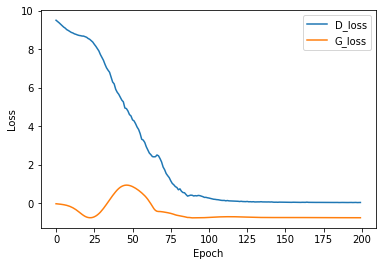

REAL (1127, 1)
PREDICTED (1127, 1)


<Figure size 432x288 with 0 Axes>

In [150]:
class GAN():
    def __init__(self, generator, discriminator):
        super(GAN, self).__init__()
        self.d_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.g_optimizer = tf.keras.optimizers.Adam(0.0001)
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = 128
        self.checkpoint = tf.train.Checkpoint(generator_optimizer=self.g_optimizer,
                                              discriminator_optimizer=self.d_optimizer,
                                              generator=self.generator,
                                              discriminator=self.discriminator)

    def gradient_penalty(self, batch_size, real_output, fake_output):
        alpha = tf.random.normal([batch_size, 8, 1], 0.0, 1.0)
        diff = fake_output - tf.cast(real_output, tf.float32)
        interpolated = tf.cast(real_output, tf.float32) + alpha * diff

        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)

        grads = gp_tape.gradient(pred, [interpolated])[0]

        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1, 2]))

        gp = tf.reduce_mean((norm - 1.0) ** 2)
        return gp

    def train_step(self, data):
        real_input, real_price, yc = data
        batch_size = tf.shape(real_input)[0]
        for _ in range(1):
            with tf.GradientTape() as d_tape:
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                real_y_reshape = tf.reshape(real_price, [real_price.shape[0], real_price.shape[1], 1])
                real_output = tf.concat([tf.cast(real_y_reshape, tf.float32), tf.cast(yc, tf.float32)], axis=1)
                # Get the logits for the fake images
                D_real = self.discriminator(real_output, training=True)
                # Get the logits for real images
                D_fake = self.discriminator(fake_output, training=True)
                # Calculate discriminator loss using fake and real logits
                real_loss = tf.cast(tf.reduce_mean(D_real), tf.float32)
                fake_loss = tf.cast(tf.reduce_mean(D_fake), tf.float32)
                d_cost = fake_loss-real_loss
                # Calculate the gradientjiu penalty
                gp = self.gradient_penalty(batch_size, real_output, fake_output)
                # Add the gradient penalty to the original discriminator loss
                d_loss = d_cost + gp * 10

            d_grads = d_tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_grads, self.discriminator.trainable_variables))
        for _ in range(3):
            with tf.GradientTape() as g_tape:
                # generate fake output
                generated_data = self.generator(real_input, training=True)
                # reshape the data
                generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
                fake_output = tf.concat([generated_data_reshape, tf.cast(yc, tf.float32)], axis=1)
                # Get the discriminator logits for fake images
                G_fake = self.discriminator(fake_output, training=True)
                # Calculate the generator loss
                g_loss = -tf.reduce_mean(G_fake)
            g_grads = g_tape.gradient(g_loss, self.generator.trainable_variables)
            self.g_optimizer.apply_gradients(zip(g_grads, self.generator.trainable_variables))

        return real_price, generated_data, {'d_loss': d_loss, 'g_loss': g_loss}

    def train(self, X_train, y_train, yc, epochs):
        data = X_train, y_train, yc
        train_hist = {}
        train_hist['D_losses'] = []
        train_hist['G_losses'] = []
        train_hist['per_epoch_times'] = []
        train_hist['total_ptime'] = []


        for epoch in range(epochs):
            start = time.time()

            real_price, fake_price, loss = self.train_step(data)

            G_losses = []
            D_losses = []

            Real_price = []
            Predicted_price = []

            D_losses.append(loss['d_loss'].numpy())
            G_losses.append(loss['g_loss'].numpy())

            Predicted_price.append(fake_price)
            Real_price.append(real_price)

            # Save the model every 15 epochs
            if (epoch + 1) % 15 == 0:
                print('epoch', epoch+1, 'd_loss', loss['d_loss'].numpy(), 'g_loss', loss['g_loss'].numpy())

            # For printing loss
            epoch_end_time = time.time()
            per_epoch_ptime = epoch_end_time - start
            train_hist['D_losses'].append(D_losses)
            train_hist['G_losses'].append(G_losses)
            train_hist['per_epoch_times'].append(per_epoch_ptime)
            
        # Reshape the predicted result & real
        Predicted_price = np.array(Predicted_price)
        Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
        Real_price = np.array(Real_price)
        Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

        # Plot the loss
        plt.plot(train_hist['D_losses'], label='D_loss')
        plt.plot(train_hist['G_losses'], label='G_loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()
        plt.savefig('train_loss.png')

        print("REAL", Real_price.shape)
        print("PREDICTED", Predicted_price.shape)

        return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

if __name__ == '__main__':
    input_dim = X_train.shape[1]
    feature_size = X_train.shape[2]
    output_dim = y_train.shape[1]
    epoch = 200

    generator = Generator(X_train.shape[1], output_dim, X_train.shape[2])
    discriminator = Discriminator()
    gan = GAN(generator, discriminator)
    Predicted_price, Real_price, RMSPE = gan.train(X_train, y_train, yc_train, epoch)     

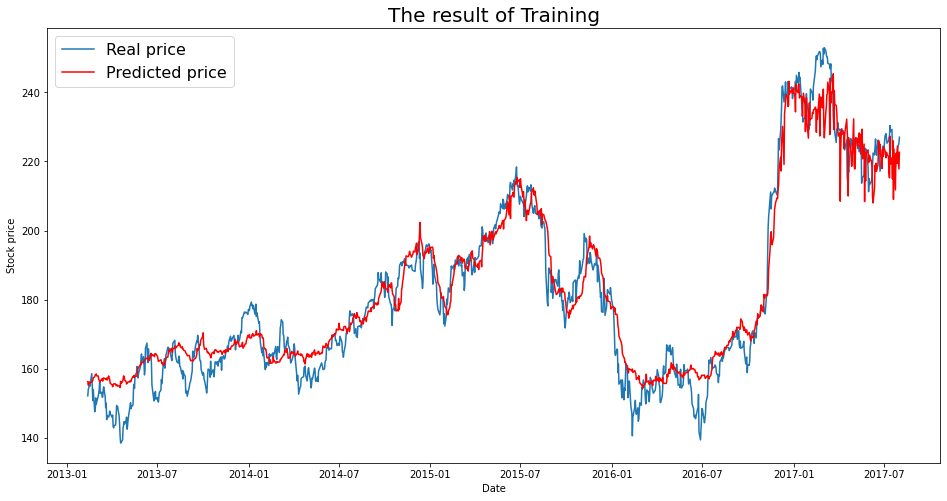

-- RMSE --  6.452456107871662


<Figure size 432x288 with 0 Axes>

In [151]:

test_predict_index = index_train

rescaled_Real_price = y_scaler.inverse_transform(Real_price)
rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

predict_result = pd.DataFrame()
for i in range(rescaled_Predicted_price.shape[0]):
    y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=index_train[i:i+output_dim])
    predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

real_price = pd.DataFrame()
for i in range(rescaled_Real_price.shape[0]):
    y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=index_train[i:i+output_dim])
    real_price = pd.concat([real_price, y_train], axis=1, sort=False)

predict_result['predicted_mean'] = predict_result.mean(axis=1)
real_price['real_mean'] = real_price.mean(axis=1)

# Plot the predicted result
plt.figure(figsize=(16, 8))
plt.plot(real_price["real_mean"])
plt.plot(predict_result["predicted_mean"], color = 'r')
plt.xlabel("Date")
plt.ylabel("Stock price")
plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
plt.title("The result of Training", fontsize=20)
plt.show()
plt.savefig('train_plot.png')

# Calculate RMSE
predicted = predict_result["predicted_mean"]
real = real_price["real_mean"]
For_MSE = pd.concat([predicted, real], axis = 1)
RMSE = np.sqrt(mean_squared_error(predicted, real))
print('-- RMSE -- ', RMSE)

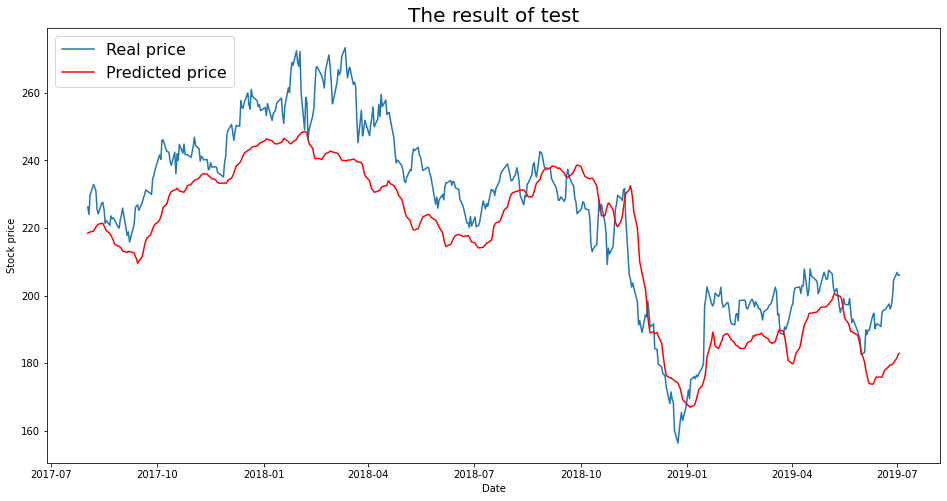

-- RMSE --  13.201991054210593


<Figure size 432x288 with 0 Axes>

In [152]:
train_predict_index = index_train
test_predict_index = index_test

def get_test_plot(X_test, y_test):
    # Set output steps
    output_dim = y_test.shape[1]

    # Get predicted data
    y_predicted = generator(X_test)
    rescaled_real_y = y_scaler.inverse_transform(y_test)
    rescaled_predicted_y = y_scaler.inverse_transform(y_predicted)

    ## Predicted price
    predict_result = pd.DataFrame()
    for i in range(rescaled_predicted_y.shape[0]):
        y_predict = pd.DataFrame(rescaled_predicted_y[i], columns=["predicted_price"],
                                 index=test_predict_index[i:i + output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    ## Real price
    real_price = pd.DataFrame()
    for i in range(rescaled_real_y.shape[0]):
        y_train = pd.DataFrame(rescaled_real_y[i], columns=["real_price"], index=test_predict_index[i:i + output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    # Plot the predicted result
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color='r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of test", fontsize=20)
    plt.show()
    plt.savefig('test_plot.png')
    # Calculate RMSE
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis=1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- RMSE -- ', RMSE)

    return predict_result, RMSE

test_predicted, test_RMSE = get_test_plot(X_test, y_test)